# Importing libraries and data

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
cardio=pd.read_csv('data_cardiovascular_risk (1).csv')

In [3]:
pd.set_option('display.max_columns',None)

# Exploratory Analysis

In [4]:
cardio.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [5]:
cardio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

In [6]:
print('\033[1mNumber of columns:\t{}\033[0m'.format(cardio.shape[1]))

Number of columns:	17


## Number of categorical and numerical columns

In [7]:
num_cat=sum([cardio[col].nunique()<20 for col in cardio.columns])

In [8]:
print('\033[1mNumber of Categorical Columns:\t{}\033[0m'.format(num_cat))

Number of Categorical Columns:	8


In [9]:
num_num=cardio.shape[1]-num_cat
print('\033[1mNumber of Numerical Columns:\t{}\033[0m'.format(num_num))

Number of Numerical Columns:	9


## Categorical Columns

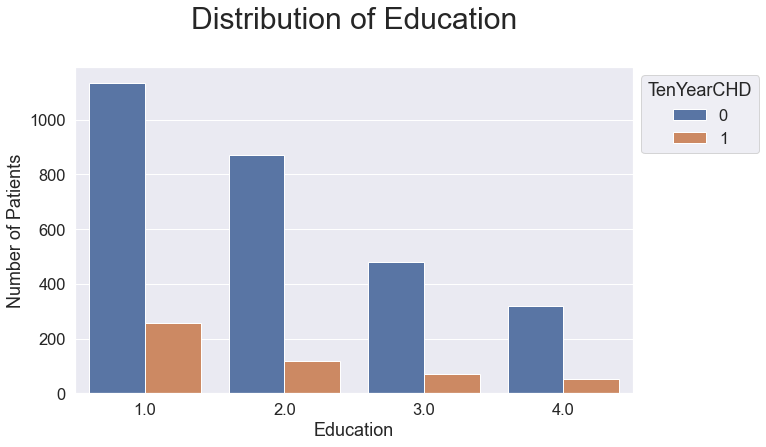

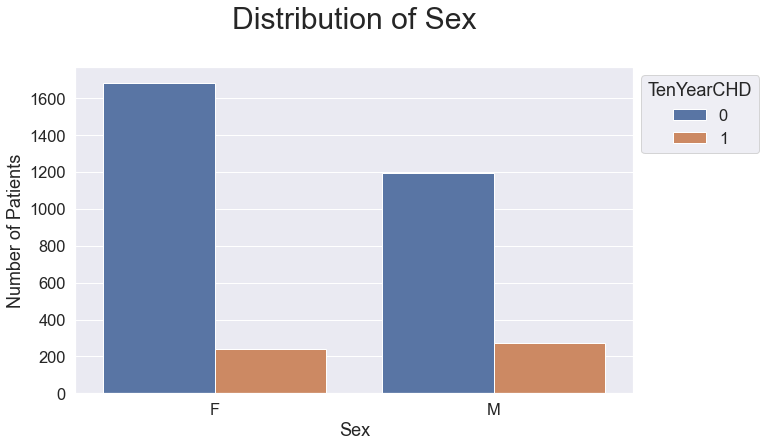

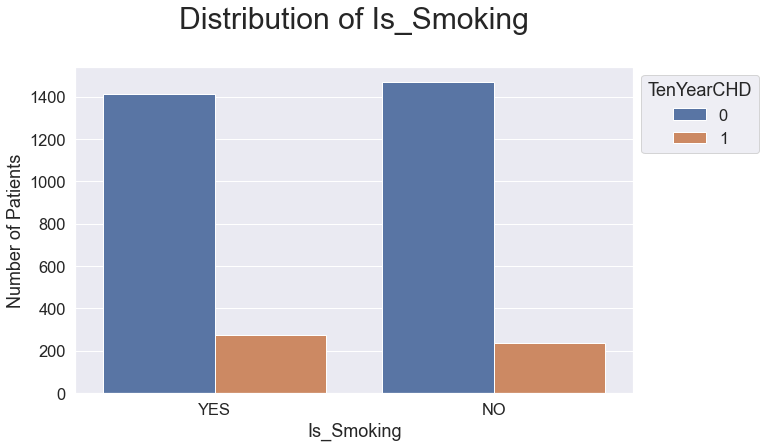

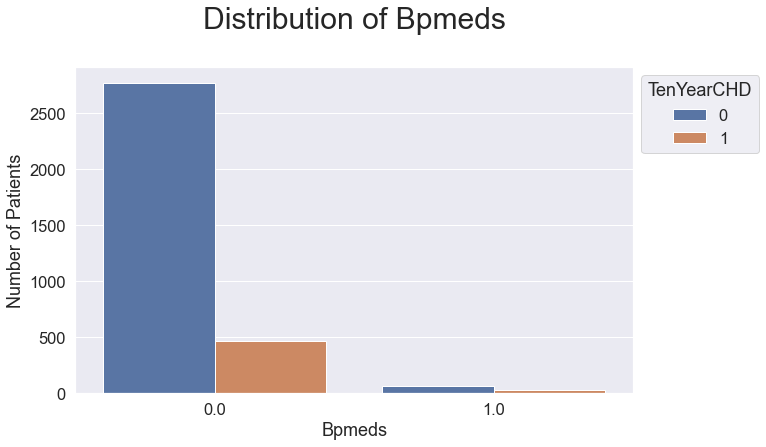

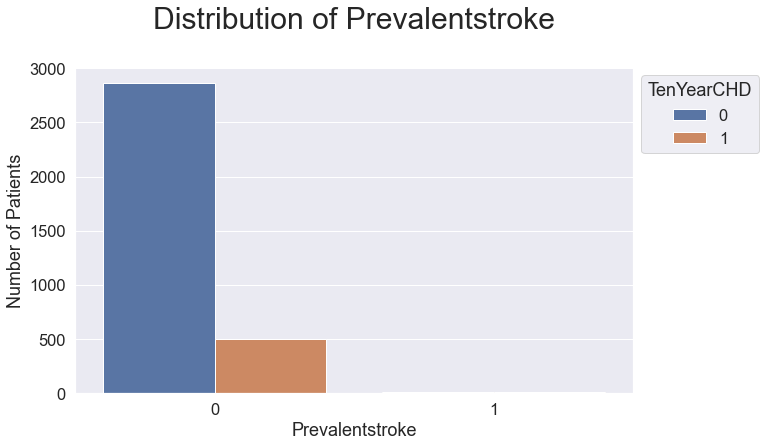

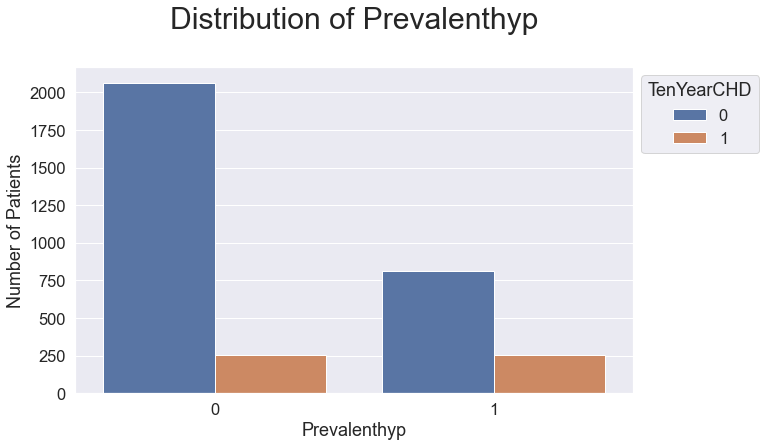

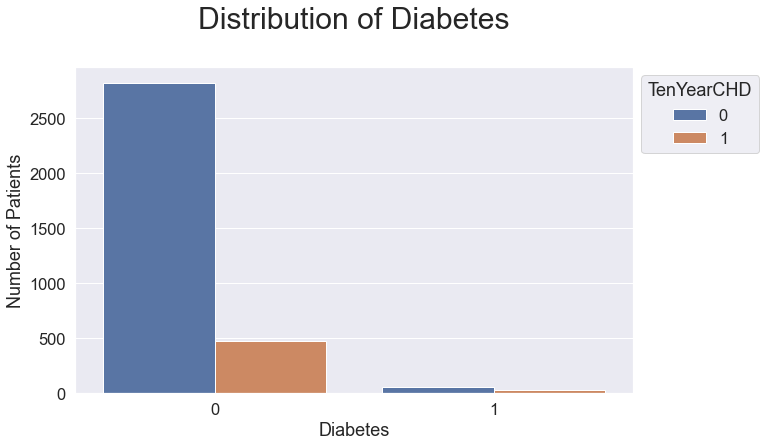

In [10]:
sns.set_theme(style='darkgrid',font_scale=1.5)

for col in cardio.columns.drop('TenYearCHD'):
    if cardio[col].nunique()<20:
        plt.figure(figsize=(10,6))
        sns.countplot(x=col,data=cardio,hue='TenYearCHD')
        plt.title('Distribution of '+col.title()+'\n',fontsize=30)
        plt.ylabel('Number of Patients')
        plt.xlabel(col.title())
        plt.legend(bbox_to_anchor=(1,1),loc='upper left',title='TenYearCHD')
        plt.show()

## Numerical Columns

In [11]:
num_cols=[col for col in cardio.columns.drop('id') if (cardio[col].nunique()>20 and cardio[col].nunique()<100)]

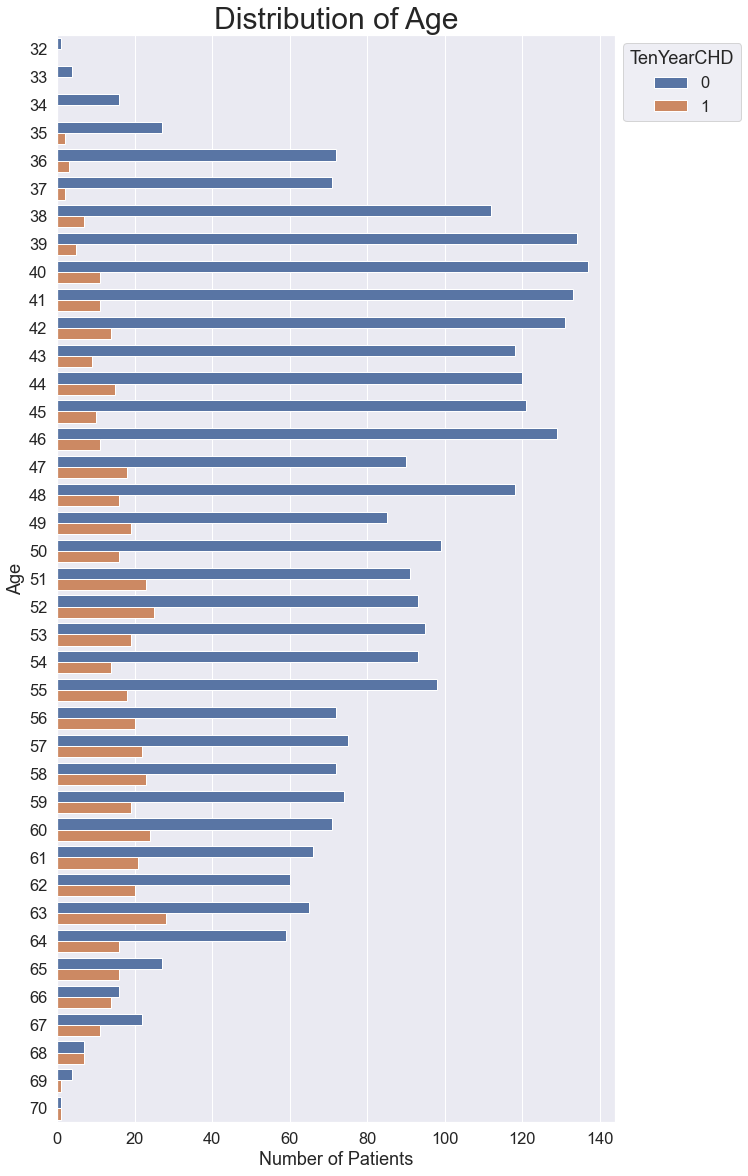

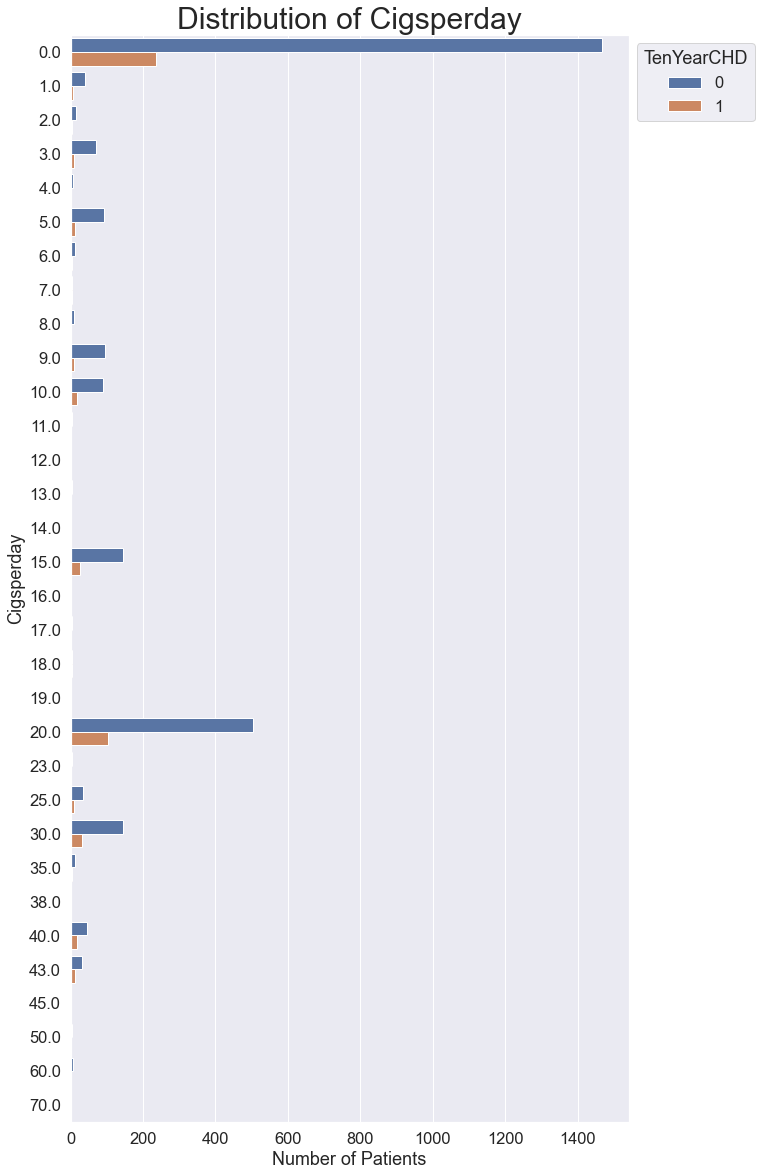

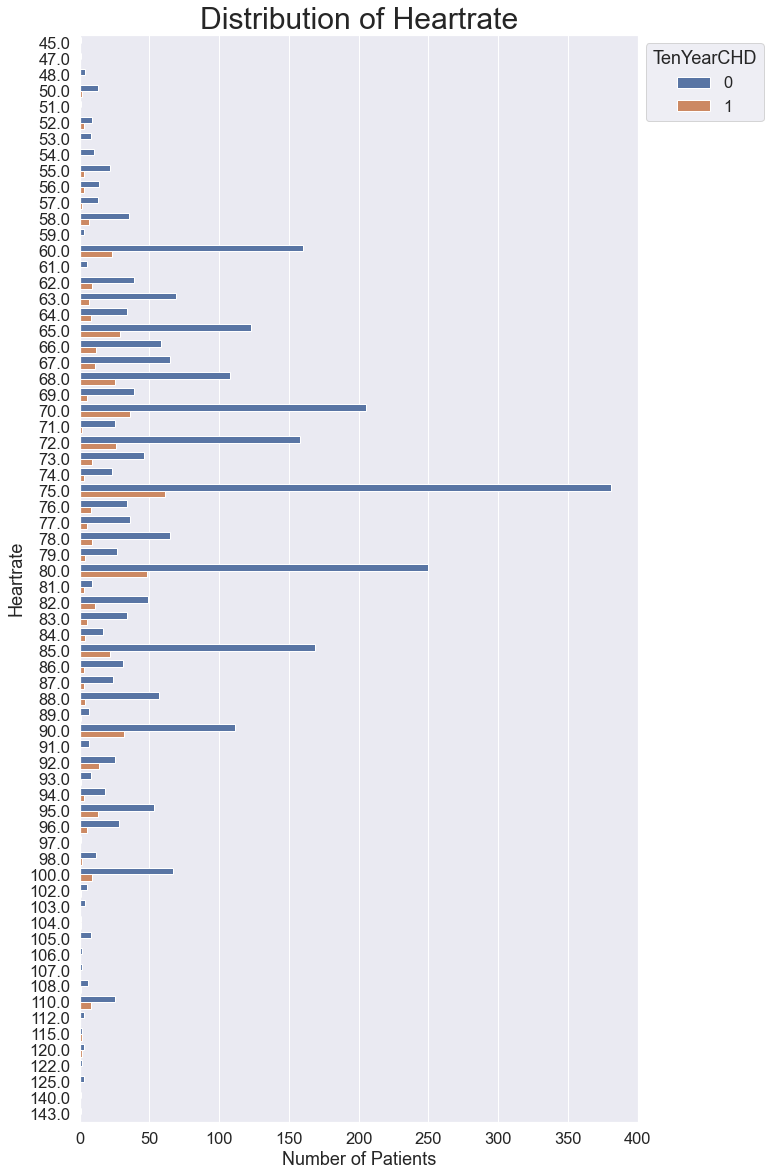

In [12]:
for col in num_cols:
    plt.figure(figsize=(10,20))
    sns.countplot(y=col,data=cardio,hue='TenYearCHD')
    plt.title('Distribution of '+col.title(),fontsize=30)
    plt.xlabel('Number of Patients')
    plt.ylabel(col.title())
    plt.legend(bbox_to_anchor=(1,1),loc='upper left',title='TenYearCHD')
    plt.show()
   

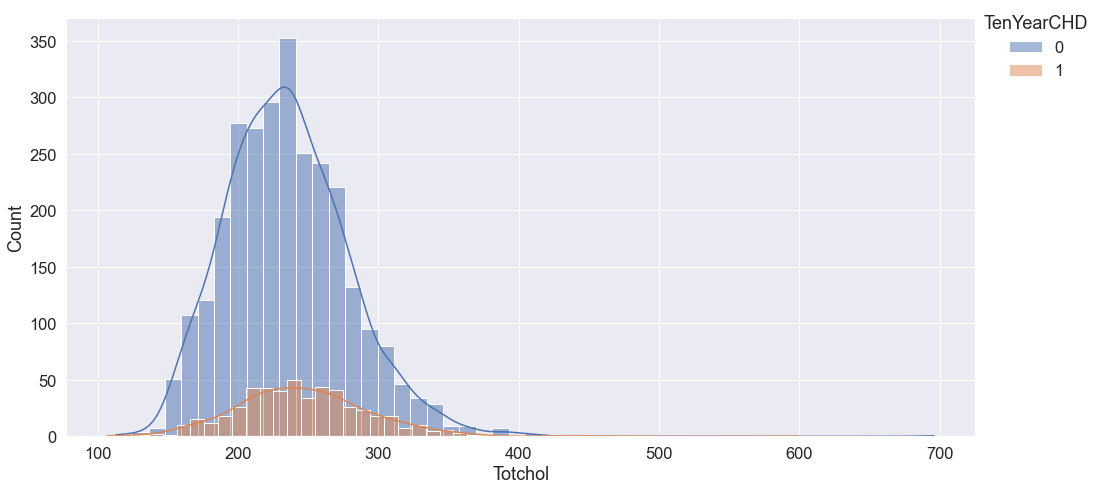

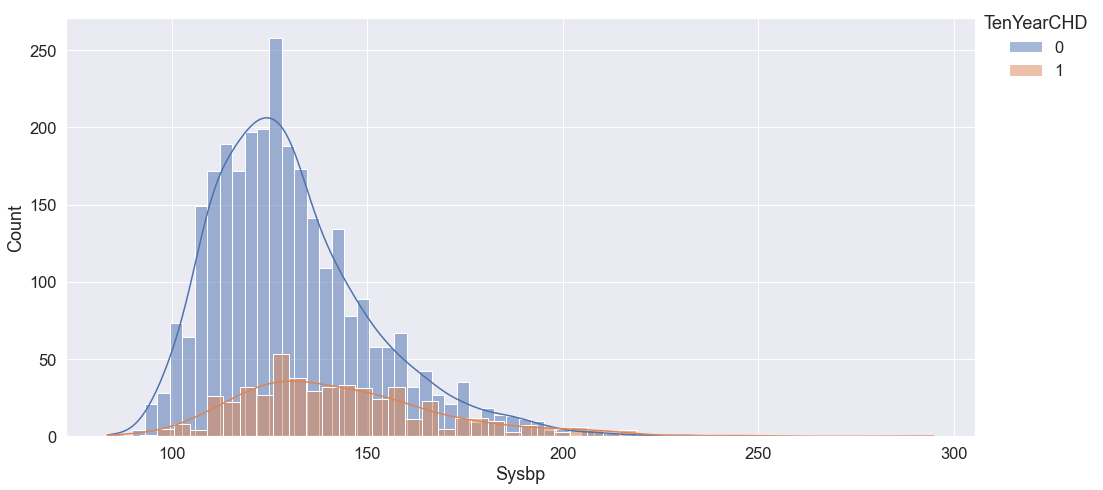

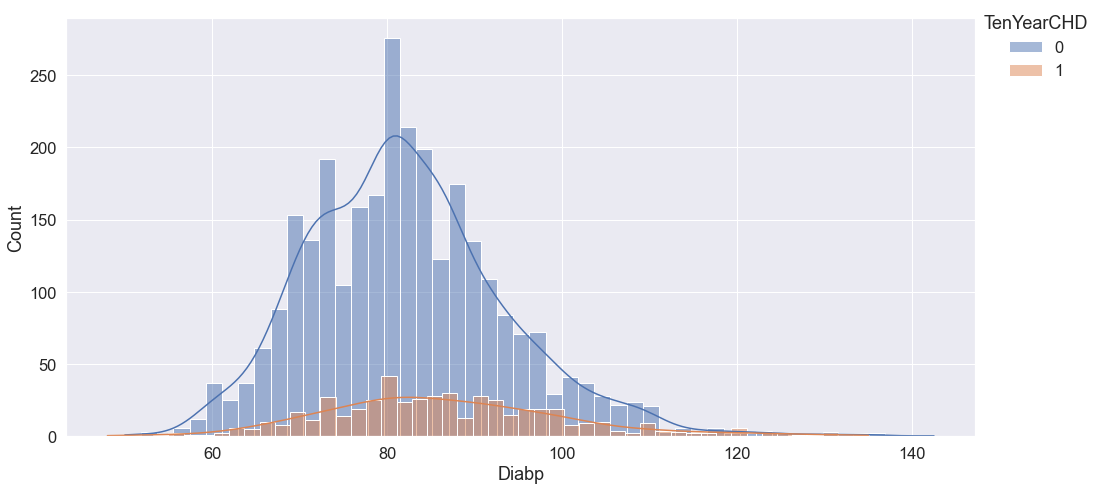

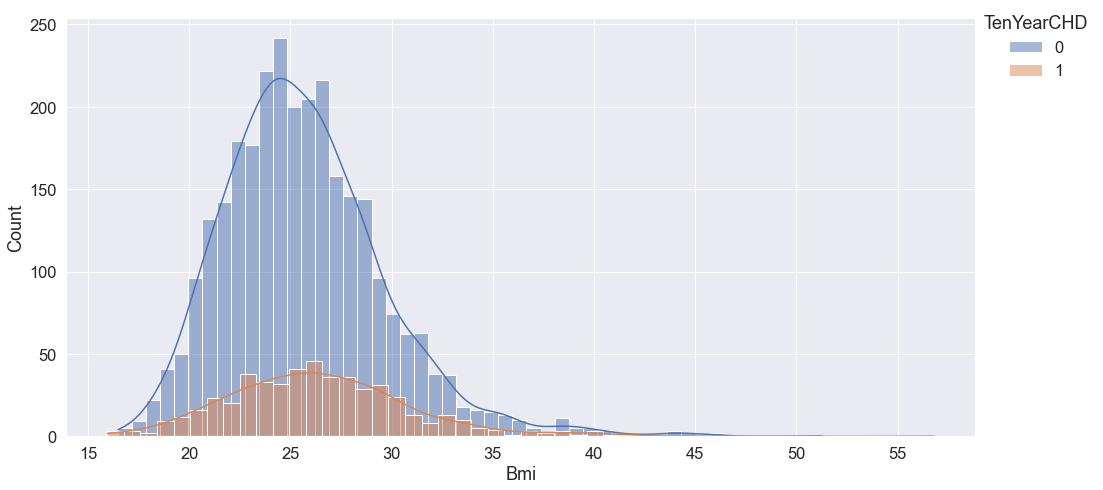

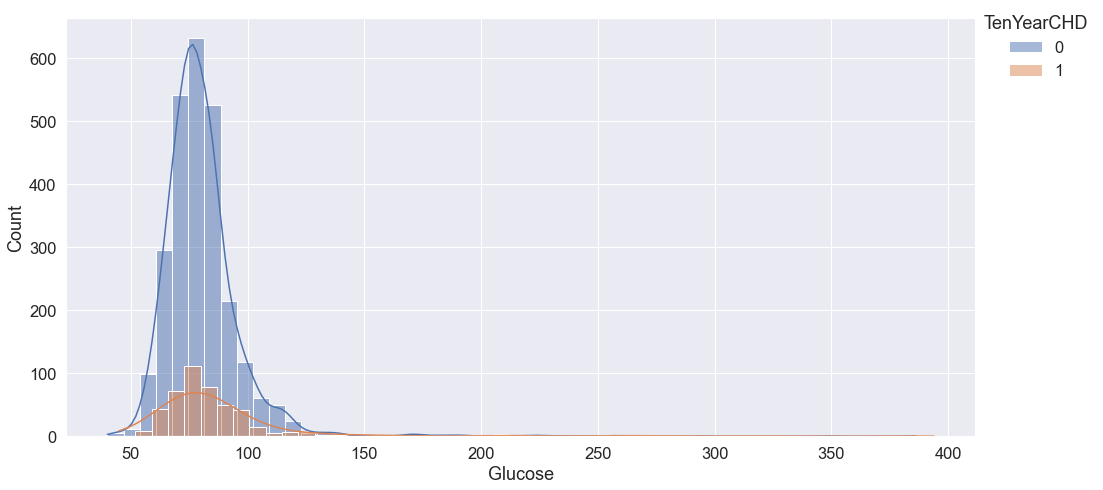

In [13]:
for col in cardio.columns.drop('id'):
    if cardio[col].nunique()>=100:
        g=sns.FacetGrid(data=cardio,hue='TenYearCHD',height=7,aspect=2,despine=False)
        g.map(sns.histplot,col,alpha=0.5,kde=True,bins=50)
        g.add_legend(title='TenYearCHD',loc='upper right')
        g.set_axis_labels(x_var=col.title())

# Preprocessing
## Missing Values

In [14]:
missing=cardio.columns[cardio.isnull().any()].tolist()

miss_num=cardio[missing].isnull().sum().sort_values(ascending=False)
miss_perc=cardio[missing].isnull().mean().sort_values(ascending=False)*100

print('\n\033[1mNumber of missing values in features:\033[0m\n')
print(miss_num.to_string().title(),'\n')
print('\033[1mPercent of missing values in features:\033[0m\n')
print(miss_perc.to_string().title())


Number of missing values in features:

Glucose       304
Education      87
Bpmeds         44
Totchol        38
Cigsperday     22
Bmi            14
Heartrate       1 

Percent of missing values in features:

Glucose       8.967552
Education     2.566372
Bpmeds        1.297935
Totchol       1.120944
Cigsperday    0.648968
Bmi           0.412979
Heartrate     0.029499


# Feature Engineering

## Imputation

In [15]:
for col in missing:
    p=cardio[col].value_counts(normalize=True).values
    c=cardio[col].value_counts().index
    one=pd.Series(np.random.choice(c,len(cardio),p=p))
    cardio[col].fillna(one,inplace=True)

## One Hot Encoding

In [16]:
onehot=OneHotEncoder(drop='first')

### Encoded Dataframe 

In [17]:
obj_df=cardio.iloc[:,[cardio[col].dtype=='O' for col in cardio.columns]]
encoded_df=pd.DataFrame(onehot.fit_transform(obj_df).toarray(),columns=obj_df.columns)

### Replacing by encoded columns

In [18]:
for col in obj_df.columns:
    cardio[col]=encoded_df[col]

In [19]:
cardio.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,0.0,1.0,3.0,0.0,0,0,0,221.0,148.0,85.0,25.10,90.0,80.0,1
1,1,36,4.0,1.0,0.0,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,0.0,1.0,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,1.0,1.0,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,0.0,1.0,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


# Prediction

In [22]:
X=cardio.iloc[:,1:-1]
y=cardio.iloc[:,-1]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33,stratify=y)

In [25]:
print("\033[1mThe shape of train dataset :",X_train.shape)
print("The shape of test dataset :",X_test.shape,'\033[0m]')

The shape of train dataset : (2712, 15)
The shape of test dataset : (678, 15) ]


In [32]:
print("\033[1mDistribution of classes of dependent variable in train \033[0m")
print(y_train.value_counts(normalize=True).to_string())
print("\n\033[1mDistribution of classes of dependent variable in test \033[0m:")
print(y_test.value_counts(normalize=True).to_string())

Distribution of classes of dependent variable in train 
0    0.849189
1    0.150811

Distribution of classes of dependent variable in test :
0    0.849558
1    0.150442


## 1. RandomForest CLassifier

### Hyper parameter tuning

In [33]:
# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# Hyperparameter Grid
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

#### Gridsearch

In [39]:
rf_grid=GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_dict, verbose=3,scoring='roc_auc')

In [40]:
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50;, score=0.708 total time=   0.1s
[CV 2/5] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50;, score=0.717 total time=   0.1s
[CV 3/5] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50;, score=0.717 total time=   0.0s
[CV 4/5] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50;, score=0.691 total time=   0.1s
[CV 5/5] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50;, score=0.694 total time=   0.1s
[CV 1/5] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80;, score=0.716 total time=   0.1s
[CV 2/5] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80;, score=0.724 total time=   0.1s
[CV 3/5] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80;, score=0.714 total time=  

[CV 5/5] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=80;, score=0.688 total time=   0.3s
[CV 1/5] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=100;, score=0.709 total time=   0.3s
[CV 2/5] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=100;, score=0.721 total time=   0.2s
[CV 3/5] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=100;, score=0.708 total time=   0.2s
[CV 4/5] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=100;, score=0.691 total time=   0.2s
[CV 5/5] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=100;, score=0.680 total time=   0.2s
[CV 1/5] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=50;, score=0.704 total time=   0.0s
[CV 2/5] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=50;, score=0.718 total time=   0.0s
[CV 3/5] END max_depth=4, min_samples_leaf=

[CV 4/5] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=50;, score=0.699 total time=   0.0s
[CV 5/5] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=50;, score=0.682 total time=   0.0s
[CV 1/5] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=80;, score=0.712 total time=   0.1s
[CV 2/5] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=80;, score=0.721 total time=   0.1s
[CV 3/5] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=80;, score=0.707 total time=   0.1s
[CV 4/5] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=80;, score=0.693 total time=   0.1s
[CV 5/5] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=80;, score=0.683 total time=   0.1s
[CV 1/5] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=100;, score=0.716 total time=   0.2s
[CV 2/5] END max_depth=6, min_samples_leaf=50, min_samp

[CV 3/5] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=100;, score=0.706 total time=   0.2s
[CV 4/5] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=100;, score=0.688 total time=   0.2s
[CV 5/5] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=100;, score=0.686 total time=   0.2s
[CV 1/5] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=50;, score=0.708 total time=   0.0s
[CV 2/5] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=50;, score=0.723 total time=   0.0s
[CV 3/5] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=50;, score=0.702 total time=   0.0s
[CV 4/5] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=50;, score=0.696 total time=   0.0s
[CV 5/5] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=50;, score=0.677 total time=   0.0s
[CV 1/5] END max_depth=8, min_samples_leaf=40

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 6, 8], 'min_samples_leaf': [40, 50],
                         'min_samples_split': [50, 100, 150],
                         'n_estimators': [50, 80, 100]},
             scoring='roc_auc', verbose=3)